Rastrigin synthetic function:

GP CBM versus GP dCBM (winner)

https://www.sfu.ca/~ssurjano/rastr.html

In [1]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5

In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
### Inputs:

obj_func = 'Rastrigin'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'CBM'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'Rastrigin':

    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb = -5.12
    ub = +5.12

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM
        }

        self.f = mode_dict[mode]

    def CBM(self, y_global_orig, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        #f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        f = (std + self.eps) * np.sqrt(Beta_CBM)
        #df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df = dsdx * np.sqrt(Beta_CBM)
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t CBM exact \t CBM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t CBM exact \t CBM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.84969467  2.25612281]	 20.33436271	 19.90840325	     	     	     	     	    
init	 [-5.1188288  -2.02411446]	 33.07414982	 19.90840325	     	     	     	     	    
init	 [-3.61721968 -4.17445279]	 53.34797472	 19.90840325	     	     	     	     	    
init	 [-3.21269544 -1.58145816]	 39.21847231	 19.90840325	     	     	     	     	    
init	 [-1.05710106  0.39748336]	 19.90840325	 19.90840325	     	     	     	     	    
1  	 [ 4.04077223 -4.24914728]	 44.65586384	 19.90840325	 19.6 	 2.82842715 	 2.82842715 	 1.0 	 7.672
2  	 [5.12       1.53885091]	 50.99631018	 19.90840325	 15.3 	 2.82842715 	 2.82842715 	 1.0 	 11.131
3  	 [-3.65509812  5.12      ]	 57.90018956	 19.90840325	 33.0 	 2.82842632 	 2.82842712 	 1.0 	 9.933
4  	 [-0.13410844 -5.12      ]	 32.28766412	 19.90840325	 34.4 	 2.8284262 	 2.82842637 	 1.0 	 10.529
5	 [ 2.27178108 -0.99371936]	 17.52053044	 17.5205

In [15]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.6554122  -4.85451539]	 43.49029625	 18.96453942	     	     	     	     	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861668	 18.96453942	     	     	     	     	    
init	 [-0.81543371 -1.73737143]	 20.47956205	 18.96453942	     	     	     	     	    
init	 [-3.02439799  1.2213347 ]	 18.96453942	 18.96453942	     	     	     	     	    
init	 [-2.05153614 -2.3876887 ]	 28.04131567	 18.96453942	     	     	     	     	    
1  	 [4.81874241 3.07464552]	 39.5674044	 18.96453942	 25.5 	 2.82842715 	 2.82842715 	 1.0 	 9.206
2  	 [ 4.84260546 -3.96517156]	 43.91613433	 18.96453942	 27.8 	 2.82842715 	 2.82842715 	 1.0 	 11.542
3  	 [0.50684745 3.5339583 ]	 52.50973815	 18.96453942	 30.0 	 2.82842714 	 2.82842714 	 1.0 	 8.154
4  	 [-3.07960242  4.80587866]	 40.36607544	 18.96453942	 40.8 	 2.82842607 	 2.82842604 	 1.0 	 10.009
5  	 [-5.12      -4.3234346]	 62.06885085	 18.964539

In [16]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.52017052 2.1314337 ]	 27.95385841	 10.60766264	     	     	     	     	    
init	 [-2.14113547  0.11087468]	 10.60766264	 10.60766264	     	     	     	     	    
init	 [4.02377681 4.05804123]	 33.42749829	 10.60766264	     	     	     	     	    
init	 [-3.83400642 -2.99783293]	 28.65095393	 10.60766264	     	     	     	     	    
init	 [-4.59297584 -0.6061072 ]	 57.66313556	 10.60766264	     	     	     	     	    
1  	 [ 2.87042319 -1.98283743]	 15.36422992	 10.60766264	 20.2 	 2.82842715 	 2.82842715 	 1.0 	 10.077
2  	 [-4.36609363  4.01810624]	 51.93709951	 10.60766264	 35.0 	 2.82842715 	 2.82842715 	 1.0 	 10.585
3  	 [-1.06170353 -5.12      ]	 30.79409756	 10.60766264	 40.4 	 2.82842401 	 2.82842535 	 1.0 	 11.687
4  	 [ 4.37118552 -5.12      ]	 64.93155707	 10.60766264	 42.8 	 2.82842406 	 2.82842518 	 1.0 	 10.81
5  	 [5.12       0.67853962]	 43.72576784	 10.6076

In [17]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [4.78238555 0.48365823]	 51.03163809	 14.32303826	     	     	     	     	    
init	 [4.84028785 2.19971578]	 39.78645699	 14.32303826	     	     	     	     	    
init	 [ 2.02474316 -2.90724357]	 14.32303826	 14.32303826	     	     	     	     	    
init	 [ 4.87705042 -5.05620219]	 52.80627247	 14.32303826	     	     	     	     	    
init	 [-2.52946061 -0.66773471]	 41.61497868	 14.32303826	     	     	     	     	    
1  	 [-0.85221064  4.14379611]	 25.71899182	 14.32303826	 23.6 	 2.82842715 	 2.82842715 	 1.0 	 7.321
2  	 [-4.62301044 -3.99546247]	 54.49891648	 14.32303826	 33.0 	 2.82842708 	 2.82842708 	 1.0 	 9.698
3  	 [-1.00715827 -5.12      ]	 29.94919433	 14.32303826	 36.2 	 2.8284261 	 2.82842667 	 1.0 	 11.895
4  	 [-5.12        2.30859273]	 47.85320454	 14.32303826	 35.7 	 2.82842171 	 2.82842709 	 1.0 	 10.754
5	 [1.25221775 0.9916883 ]	 12.70446972	 12.70446972

In [18]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.84678993  3.79629882]	 33.93442009	 7.8108627	     	     	     	     	    
init	 [-3.00319585  4.2865757 ]	 39.67387608	 7.8108627	     	     	     	     	    
init	 [-0.11866943  1.14425716]	 7.8108627	 7.8108627	     	     	     	     	    
init	 [2.72289645 0.1886002 ]	 25.38160396	 7.8108627	     	     	     	     	    
init	 [-2.08076286 -3.19773462]	 22.58998212	 7.8108627	     	     	     	     	    
1  	 [ 4.32895605 -5.09732646]	 61.29478907	 7.8108627	 24.0 	 2.82842715 	 2.82842715 	 1.0 	 7.37
2  	 [4.02415917 4.76321328]	 48.16778619	 7.8108627	 31.0 	 2.82842715 	 2.82842715 	 1.0 	 8.616
3  	 [-4.50499295  0.59896212]	 58.77712488	 7.8108627	 34.4 	 2.82842601 	 2.82842629 	 1.0 	 10.345
4  	 [-5.08995628 -5.12      ]	 56.38761769	 7.8108627	 35.8 	 2.8284262 	 2.82842613 	 1.0 	 10.013
5  	 [0.55353466 4.92885023]	 45.02228582	 7.8108627	 38.1 	 2.82842012 	

In [19]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 4.02288795 -1.72052679]	 31.0883571	 17.28954483	     	     	     	     	    
init	 [ 3.28938622 -4.69302655]	 58.79786772	 17.28954483	     	     	     	     	    
init	 [-4.0175956   0.97333314]	 17.28954483	 17.28954483	     	     	     	     	    
init	 [ 0.30532979 -0.83141193]	 19.29625316	 17.28954483	     	     	     	     	    
init	 [-1.68542362  1.25459899]	 28.65063094	 17.28954483	     	     	     	     	    
1  	 [4.87990293 3.44994399]	 57.93953348	 17.28954483	 26.4 	 2.82842715 	 2.82842715 	 1.0 	 9.977
2  	 [-2.54347117 -4.69631487]	 61.46344508	 17.28954483	 35.1 	 2.82842715 	 2.82842715 	 1.0 	 13.292
3  	 [-1.10963196  5.12      ]	 32.43614462	 17.28954483	 32.7 	 2.82842705 	 2.82842707 	 1.0 	 9.926
4  	 [-5.12        4.35890853]	 64.24604669	 17.28954483	 37.6 	 2.82842362 	 2.82842603 	 1.0 	 9.585
5  	 [-5.12       -2.37655667]	 51.71262488	 17.289

In [20]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.33860312  2.86636843]	 45.64613307	 22.52235438	     	     	     	     	    
init	 [-0.63068947  2.28828342]	 34.83012663	 22.52235438	     	     	     	     	    
init	 [4.8946126  0.39419771]	 44.09657006	 22.52235438	     	     	     	     	    
init	 [ 0.01147355 -4.38219639]	 36.61320982	 22.52235438	     	     	     	     	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235438	 22.52235438	     	     	     	     	    
1  	 [-5.10538874 -4.17523358]	 51.08419006	 22.52235438	 32.4 	 2.82842715 	 2.82842715 	 1.0 	 7.91
2  	 [3.63690937 5.12      ]	 58.67447798	 22.52235438	 30.6 	 2.82842715 	 2.82842715 	 1.0 	 9.092
3  	 [ 3.81570236 -4.87523301]	 47.23412781	 22.52235438	 35.6 	 2.82842701 	 2.82842701 	 1.0 	 9.631
4  	 [-4.02558214 -1.33646422]	 33.28973849	 22.52235438	 3.2 	 2.82842715 	 2.82842715 	 1.0 	 3.08
5  	 [ 1.30700083 -0.77550987]	 24.21908047	 22.

In [21]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [3.82391708 4.79785639]	 50.20079447	 13.87182102	     	     	     	     	    
init	 [3.78055209 0.31596228]	 36.51142516	 13.87182102	     	     	     	     	    
init	 [-2.73686192 -5.00327624]	 43.34985765	 13.87182102	     	     	     	     	    
init	 [-0.7119993  -0.99992207]	 13.87182102	 13.87182102	     	     	     	     	    
init	 [ 0.23218863 -0.22126801]	 17.19059036	 13.87182102	     	     	     	     	    
1  	 [ 4.96383424 -4.82578382]	 53.60118143	 13.87182102	 25.6 	 2.82842715 	 2.82842715 	 1.0 	 7.382
2  	 [-5.03492225  2.95509263]	 34.71822332	 13.87182102	 24.8 	 2.82842715 	 2.82842715 	 1.0 	 11.881
3  	 [-4.87140206 -2.11184191]	 33.65016329	 13.87182102	 35.4 	 2.82842712 	 2.82842628 	 1.0 	 10.482
4  	 [0.39589918 3.58374752]	 49.58324636	 13.87182102	 31.0 	 2.82842492 	 2.82842633 	 1.0 	 9.864
5  	 [ 0.86237992 -4.20868669]	 29.40126304	 13.87182

In [22]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-5.01376866  0.01919582]	 25.24828903	 24.45480031	     	     	     	     	    
init	 [-0.04328148 -3.74958562]	 24.45480031	 24.45480031	     	     	     	     	    
init	 [-3.66478248 -2.88195916]	 39.46509427	 24.45480031	     	     	     	     	    
init	 [-0.83447623 -2.57944404]	 31.06766398	 24.45480031	     	     	     	     	    
init	 [-4.25922917 -1.58209393]	 49.92254356	 24.45480031	     	     	     	     	    
1  	 [3.11029524 4.9495987 ]	 36.97642607	 24.45480031	 14.1 	 2.82842715 	 2.82842715 	 1.0 	 11.143
2  	 [-2.02106223  4.82097351]	 33.10085788	 24.45480031	 21.8 	 2.82842715 	 2.82842715 	 1.0 	 6.377
3	 [2.0867143  0.36749559]	 22.66725763	 22.66725763	 23.8 	 2.82842714 	 2.82842714 	 1.0 	 7.45
4  	 [ 4.43889093 -3.24498238]	 59.19033586	 22.66725763	 33.2 	 2.82842715 	 2.82842715 	 1.0 	 7.879
5  	 [-1.58041924  1.17954446]	 28.35572235	 22.6672576

In [23]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.77832339 -4.90750004]	 41.67433019	 13.83945831	     	     	     	     	    
init	 [1.36855793 2.54775176]	 44.69639719	 13.83945831	     	     	     	     	    
init	 [-0.01528819 -2.81808235]	 13.83945831	 13.83945831	     	     	     	     	    
init	 [-3.09183626  2.66783449]	 33.23221511	 13.83945831	     	     	     	     	    
init	 [-3.38830503 -4.2154003 ]	 54.73014367	 13.83945831	     	     	     	     	    
1  	 [4.54922969 4.99328486]	 65.16269429	 13.83945831	 29.2 	 2.82842712 	 2.82842712 	 1.0 	 7.088
2  	 [ 4.88530663 -0.60647603]	 44.56456522	 13.83945831	 30.8 	 2.82842715 	 2.82842715 	 1.0 	 7.589
3  	 [-5.12       -1.10049737]	 32.06404629	 13.83945831	 45.6 	 2.82842403 	 2.82842607 	 1.0 	 9.972
4  	 [-0.79278055  5.12      ]	 36.89748586	 13.83945831	 36.9 	 2.82841835 	 2.82841834 	 1.0 	 10.506
5  	 [-5.12  5.12]	 57.84942745	 13.83945831	 38.8 	

In [24]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.27403839 -4.92057353]	 47.65564129	 10.67975525	     	     	     	     	    
init	 [-0.37664229  2.30332343]	 35.87889241	 10.67975525	     	     	     	     	    
init	 [-0.81711509 -0.14922651]	 10.67975525	 10.67975525	     	     	     	     	    
init	 [-4.98912446 -0.12931474]	 28.05462906	 10.67975525	     	     	     	     	    
init	 [4.52410012 3.59214172]	 71.62694632	 10.67975525	     	     	     	     	    
1  	 [ 3.03550212 -4.46785095]	 49.22040432	 10.67975525	 30.6 	 2.82842715 	 2.82842715 	 1.0 	 8.676
2  	 [5.02497284 0.07913932]	 26.59047392	 10.67975525	 35.6 	 2.82842591 	 2.82842595 	 1.0 	 8.621
3  	 [-3.90183987  3.35466039]	 44.43271959	 10.67975525	 41.6 	 2.82840045 	 2.8284261 	 1.0 	 9.171
4  	 [1.44618863 5.12      ]	 50.45001861	 10.67975525	 36.9 	 2.8284033 	 2.82841995 	 1.0 	 6.106
5  	 [-0.20435345 -3.53113634]	 39.49102908	 10.67975525	

In [25]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.54137249  2.45810889]	 57.90324287	 40.51116653	     	     	     	     	    
init	 [-2.42365424  0.34549139]	 40.51116653	 40.51116653	     	     	     	     	    
init	 [-4.97075238  4.28796936]	 55.62655915	 40.51116653	     	     	     	     	    
init	 [ 4.10332011 -4.77776458]	 49.96280346	 40.51116653	     	     	     	     	    
init	 [ 4.6791612  -3.71497655]	 62.18389147	 40.51116653	     	     	     	     	    
1  	 [4.61121049 2.73895066]	 57.11523489	 40.51116653	 22.8 	 2.82842715 	 2.82842715 	 1.0 	 6.79
2  	 [-1.92221187 -4.40449357]	 42.51816994	 40.51116653	 24.0 	 2.82842715 	 2.82842715 	 1.0 	 7.131
3	 [0.76219182 2.84343759]	 22.36141765	 22.36141765	 28.0 	 2.82842699 	 2.82842699 	 1.0 	 7.848
4  	 [ 2.47156837 -0.37978654]	 43.37424721	 22.36141765	 32.1 	 2.82842555 	 2.82842631 	 1.0 	 8.515
5  	 [-4.94221639 -2.26667105]	 41.26073235	 22.36141765

In [26]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.84367268 -2.68757791]	 33.5801983	 17.43582664	     	     	     	     	    
init	 [3.32061217 4.76927179]	 56.857058	 17.43582664	     	     	     	     	    
init	 [ 4.83943541 -0.47667971]	 48.21191936	 17.43582664	     	     	     	     	    
init	 [1.11659482 2.82139151]	 17.43582664	 17.43582664	     	     	     	     	    
init	 [1.45012065 2.27346667]	 38.25352329	 17.43582664	     	     	     	     	    
1  	 [-4.10876704 -2.60547476]	 43.79941556	 17.43582664	 17.2 	 2.82842715 	 2.82842715 	 1.0 	 6.836
2  	 [-3.79946932  2.66821301]	 43.41250943	 17.43582664	 32.2 	 2.82842715 	 2.82842715 	 1.0 	 11.977
3  	 [-0.80178199 -0.61076847]	 25.49369818	 17.43582664	 33.9 	 2.82842587 	 2.82842648 	 1.0 	 10.527
4  	 [ 0.16294114 -5.12      ]	 33.74993095	 17.43582664	 34.4 	 2.82842095 	 2.82842643 	 1.0 	 10.008
5  	 [ 5.12 -5.12]	 57.84942745	 17.43582664	 32.8 	 2.

In [27]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.14277984 2.79721013]	 18.68308526	 10.4238386	     	     	     	     	    
init	 [ 3.7931795  -5.03759925]	 47.36348784	 10.4238386	     	     	     	     	    
init	 [-1.94830412  4.68586229]	 40.19779334	 10.4238386	     	     	     	     	    
init	 [ 0.13431513 -1.86076749]	 10.4238386	 10.4238386	     	     	     	     	    
init	 [ 0.40140736 -2.85434939]	 30.35354874	 10.4238386	     	     	     	     	    
1  	 [-4.59142601 -1.8849894 ]	 45.52863938	 10.4238386	 24.3 	 2.82842715 	 2.82842715 	 1.0 	 9.284
2  	 [4.45447136 5.0693151 ]	 66.06737826	 10.4238386	 27.0 	 2.82842715 	 2.82842715 	 1.0 	 7.201
3  	 [ 5.12       -0.99120294]	 29.92246894	 10.4238386	 32.4 	 2.82842714 	 2.82842715 	 1.0 	 10.687
4  	 [-5.12        1.64320834]	 47.84247793	 10.4238386	 38.8 	 2.82842553 	 2.8284261 	 1.0 	 8.323
5  	 [-2.32182591 -5.12      ]	 48.67690599	 10.4238386	 39.6 	

In [28]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 3.57189322 -3.28810573]	 54.93848777	 7.99076531	     	     	     	     	    
init	 [-4.56332069 -1.41784631]	 60.75019875	 7.99076531	     	     	     	     	    
init	 [-2.29989449  0.3072023 ]	 31.98499725	 7.99076531	     	     	     	     	    
init	 [-1.9873903  -2.00218256]	 7.99076531	 7.99076531	     	     	     	     	    
init	 [-3.97576933 -2.5610341 ]	 41.75495777	 7.99076531	     	     	     	     	    
1  	 [2.7754098  2.98802689]	 25.06971717	 7.99076531	 29.0 	 2.82842715 	 2.82842715 	 1.0 	 7.64
2  	 [-4.96635744  4.09320867]	 43.30810083	 7.99076531	 31.2 	 2.82842715 	 2.82842715 	 1.0 	 10.574
3  	 [-1.52549549  5.12      ]	 51.12381554	 7.99076531	 36.2 	 2.82842583 	 2.82842626 	 1.0 	 9.793
4  	 [ 0.27547173 -4.86608022]	 38.68435628	 7.99076531	 33.6 	 2.82842537 	 2.82842601 	 1.0 	 8.805
5  	 [5.12       0.27452861]	 40.53516403	 7.99076531	 37.6 	

In [29]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.83349935  0.23719262]	 22.27210457	 22.27210457	     	     	     	     	    
init	 [ 0.51918292 -4.65303603]	 57.57021076	 22.27210457	     	     	     	     	    
init	 [-1.42613673 -2.83565116]	 33.89145899	 22.27210457	     	     	     	     	    
init	 [ 1.9325559  -3.44339021]	 35.85029586	 22.27210457	     	     	     	     	    
init	 [-4.39987336  4.51595121]	 77.78800882	 22.27210457	     	     	     	     	    
1  	 [2.142749   4.83374619]	 36.6938185	 22.27210457	 28.5 	 2.82842715 	 2.82842715 	 1.0 	 7.227
2  	 [4.72424646 1.54809781]	 55.87301984	 22.27210457	 31.8 	 2.82842715 	 2.82842714 	 1.0 	 13.405
3	 [1.02167117 0.06318095]	 1.91802609	 1.91802609	 33.4 	 2.8284256 	 2.82842608 	 1.0 	 12.35
4  	 [-5.1050856  -2.62834329]	 51.99281488	 1.91802609	 37.2 	 2.82842604 	 2.82842615 	 1.0 	 9.658
5  	 [ 5.05776336 -5.12      ]	 55.15710567	 1.91802609	 36.3

In [30]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.10263037  0.31320838]	 20.39514536	 20.39514536	     	     	     	     	    
init	 [-3.15882714 -4.42470033]	 53.03732051	 20.39514536	     	     	     	     	    
init	 [2.93873111 1.60085526]	 29.98922481	 20.39514536	     	     	     	     	    
init	 [1.40821398 0.77417363]	 29.45198942	 20.39514536	     	     	     	     	    
init	 [-4.71999574 -1.45598869]	 55.89242174	 20.39514536	     	     	     	     	    
1  	 [ 4.96008736 -4.44720822]	 64.14783177	 20.39514536	 28.4 	 2.82842715 	 2.82842715 	 1.0 	 10.825
2  	 [-1.95646705  4.77829278]	 35.26326039	 20.39514536	 24.8 	 2.82842715 	 2.82842715 	 1.0 	 8.432
3  	 [ 0.85060064 -3.51017429]	 37.11607635	 20.39514536	 33.0 	 2.82842713 	 2.82842713 	 1.0 	 9.024
4  	 [-4.98471421  2.75299081]	 42.28451333	 20.39514536	 35.6 	 2.82842613 	 2.82842631 	 1.0 	 8.474
5  	 [3.92862014 5.04095826]	 42.1636176	 20.3951453

In [31]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [1.53983224 0.05584255]	 22.67190581	 22.67190581	     	     	     	     	    
init	 [ 3.87687906 -3.25795609]	 38.99009942	 22.67190581	     	     	     	     	    
init	 [3.60686662 2.56139557]	 56.66448699	 22.67190581	     	     	     	     	    
init	 [1.70088108 4.99604939]	 40.89405932	 22.67190581	     	     	     	     	    
init	 [-2.48864335 -4.83014733]	 54.67257498	 22.67190581	     	     	     	     	    
1  	 [-5.00718904  2.9174042 ]	 34.91005809	 22.67190581	 24.2 	 2.82842715 	 2.82842715 	 1.0 	 9.393
2	 [-3.10840374 -1.1627454 ]	 18.03364325	 18.03364325	 31.5 	 2.8284268 	 2.8284268 	 1.0 	 8.915
3  	 [-1.42282695  2.87154428]	 32.20157387	 18.03364325	 36.4 	 2.82842544 	 2.82842598 	 1.0 	 9.503
4  	 [ 1.03023023 -5.12      ]	 30.16593646	 18.03364325	 31.2 	 2.82842267 	 2.82842245 	 1.0 	 7.353
5  	 [ 5.12       -0.27349427]	 40.47034612	 18.03364325	 3

In [32]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.12125592  2.6751971 ]	 41.43485596	 25.86700384	     	     	     	     	    
init	 [-2.59135515 -3.70553152]	 51.60126035	 25.86700384	     	     	     	     	    
init	 [-1.72598719 -4.27008445]	 43.97430127	 25.86700384	     	     	     	     	    
init	 [1.76104531 3.13952049]	 25.86700384	 25.86700384	     	     	     	     	    
init	 [4.9432772  1.38916592]	 44.66580307	 25.86700384	     	     	     	     	    
1  	 [ 4.82682643 -3.73084389]	 53.77630571	 25.86700384	 20.4 	 2.82842715 	 2.82842715 	 1.0 	 6.927
2	 [ 0.91885627 -1.50237801]	 24.37209957	 24.37209957	 33.2 	 2.82842676 	 2.828427 	 1.0 	 8.993
3  	 [5.12 5.12]	 57.84942745	 24.37209957	 37.8 	 2.82842676 	 2.82842676 	 1.0 	 10.386
4  	 [-4.94044862 -0.9051206 ]	 27.64410876	 24.37209957	 34.8 	 2.82842606 	 2.82842606 	 1.0 	 8.163
5  	 [-1.15682247  5.12      ]	 34.73719307	 24.37209957	 39.0 	 2.828

In [33]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.9024594  4.07258857]	 20.24255448	 17.38869134	     	     	     	     	    
init	 [4.00927467 3.23417577]	 35.55852255	 17.38869134	     	     	     	     	    
init	 [-4.75249064  1.96359764]	 36.54582989	 17.38869134	     	     	     	     	    
init	 [-1.24230715  0.18955208]	 17.38869134	 17.38869134	     	     	     	     	    
init	 [ 1.61742301 -3.13497377]	 33.2293287	 17.38869134	     	     	     	     	    
1  	 [-2.67107132  5.12      ]	 50.81777702	 17.38869134	 38.1 	 2.82842591 	 2.8284266 	 1.0 	 11.527
2  	 [-4.75610085 -3.8764158 ]	 50.13017164	 17.38869134	 28.6 	 2.82842715 	 2.82842715 	 1.0 	 8.623
3  	 [ 5.12 -5.12]	 57.84942745	 17.38869134	 33.8 	 2.82842582 	 2.82842712 	 1.0 	 15.878
4  	 [ 5.12       -0.15948081]	 33.56436507	 17.38869134	 35.2 	 2.82842568 	 2.82842613 	 1.0 	 9.657
5  	 [-1.44394023 -5.12      ]	 50.39572075	 17.38869134	 43.4 	 

In [34]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.84969467  2.25612281]	 20.33436271	 19.90840325	     	     	     	     	    
init	 [-5.1188288  -2.02411446]	 33.07414982	 19.90840325	     	     	     	     	    
init	 [-3.61721968 -4.17445279]	 53.34797472	 19.90840325	     	     	     	     	    
init	 [-3.21269544 -1.58145816]	 39.21847231	 19.90840325	     	     	     	     	    
init	 [-1.05710106  0.39748336]	 19.90840325	 19.90840325	     	     	     	     	    
1  	 [ 4.04077223 -4.24914728]	 44.65586384	 19.90840325	 4.5 	 2.82842715 	 2.82842715 	 1.0 	 5.864
2  	 [5.12 5.12]	 57.84942745	 19.90840325	 4.7 	 2.82842715 	 2.82842715 	 1.0 	 14.496
3  	 [4.78490962 0.69734873]	 44.45393013	 19.90840325	 7.6 	 2.82842715 	 2.82842715 	 1.0 	 8.47
4  	 [-4.89958599  4.58721496]	 65.50937696	 19.90840325	 11.8 	 2.82842715 	 2.82842715 	 1.0 	 9.592
5  	 [ 0.5934114 -5.12     ]	 47.60334786	 19.90840325	 11.9 	 2.828

In [35]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.6554122  -4.85451539]	 43.49029625	 18.96453942	     	     	     	     	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861668	 18.96453942	     	     	     	     	    
init	 [-0.81543371 -1.73737143]	 20.47956205	 18.96453942	     	     	     	     	    
init	 [-3.02439799  1.2213347 ]	 18.96453942	 18.96453942	     	     	     	     	    
init	 [-2.05153614 -2.3876887 ]	 28.04131567	 18.96453942	     	     	     	     	    
1  	 [4.81874241 3.07464552]	 39.5674044	 18.96453942	 7.0 	 2.82842715 	 2.82842715 	 1.0 	 9.02
2  	 [ 4.84260546 -3.96517156]	 43.91613433	 18.96453942	 9.6 	 2.82842715 	 2.82842715 	 1.0 	 6.92
3  	 [0.50684745 3.5339583 ]	 52.50973815	 18.96453942	 12.5 	 2.82842714 	 2.82842714 	 1.0 	 11.574
4  	 [-4.40363105 -5.12      ]	 66.53883385	 18.96453942	 13.8 	 2.82842607 	 2.82842604 	 1.0 	 8.409
5  	 [ 4.85858539 -0.35830455]	 43.72052841	 18.96453942	

In [36]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.52017052 2.1314337 ]	 27.95385841	 10.60766264	     	     	     	     	    
init	 [-2.14113547  0.11087468]	 10.60766264	 10.60766264	     	     	     	     	    
init	 [4.02377681 4.05804123]	 33.42749829	 10.60766264	     	     	     	     	    
init	 [-3.83400642 -2.99783293]	 28.65095393	 10.60766264	     	     	     	     	    
init	 [-4.59297584 -0.6061072 ]	 57.66313556	 10.60766264	     	     	     	     	    
1  	 [ 2.87042319 -1.98283743]	 15.36422992	 10.60766264	 6.4 	 2.82842715 	 2.82842715 	 1.0 	 4.687
2  	 [-4.36609363  4.01810624]	 51.93709951	 10.60766264	 8.1 	 2.82842715 	 2.82842715 	 1.0 	 8.431
3  	 [5.12      0.6509897]	 45.17593208	 10.60766264	 15.0 	 2.82842401 	 2.82842535 	 1.0 	 9.019
4  	 [-0.21590577 -4.48225812]	 47.9493267	 10.60766264	 8.1 	 2.82842702 	 2.82842702 	 1.0 	 7.879
5  	 [ 2.89275183 -5.12      ]	 39.47853927	 10.60766264	 11.

In [37]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [4.78238555 0.48365823]	 51.03163809	 14.32303826	     	     	     	     	    
init	 [4.84028785 2.19971578]	 39.78645699	 14.32303826	     	     	     	     	    
init	 [ 2.02474316 -2.90724357]	 14.32303826	 14.32303826	     	     	     	     	    
init	 [ 4.87705042 -5.05620219]	 52.80627247	 14.32303826	     	     	     	     	    
init	 [-2.52946061 -0.66773471]	 41.61497868	 14.32303826	     	     	     	     	    
1  	 [-0.85221064  4.14379611]	 25.71899182	 14.32303826	 6.8 	 2.82842715 	 2.82842715 	 1.0 	 6.736
2  	 [-4.62301044 -3.99546247]	 54.49891648	 14.32303826	 9.8 	 2.82842708 	 2.82842708 	 1.0 	 9.225
3  	 [1.12228096 0.68518006]	 18.49924609	 14.32303826	 14.9 	 2.8284261 	 2.82842667 	 1.0 	 10.72
4  	 [-3.39303942  2.26638176]	 45.50213292	 14.32303826	 13.4 	 2.82838019 	 2.82842715 	 1.0 	 11.026
5  	 [-0.75839739 -5.12      ]	 38.97250146	 14.32303826	

In [38]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.84678993  3.79629882]	 33.93442009	 7.8108627	     	     	     	     	    
init	 [-3.00319585  4.2865757 ]	 39.67387608	 7.8108627	     	     	     	     	    
init	 [-0.11866943  1.14425716]	 7.8108627	 7.8108627	     	     	     	     	    
init	 [2.72289645 0.1886002 ]	 25.38160396	 7.8108627	     	     	     	     	    
init	 [-2.08076286 -3.19773462]	 22.58998212	 7.8108627	     	     	     	     	    
1  	 [ 4.32895605 -5.09732646]	 61.29478907	 7.8108627	 7.4 	 2.82842715 	 2.82842715 	 1.0 	 7.703
2  	 [4.02415917 4.76321328]	 48.16778619	 7.8108627	 10.0 	 2.82842715 	 2.82842715 	 1.0 	 9.096
3  	 [-4.3039995  0.5439134]	 51.77017951	 7.8108627	 16.4 	 2.82842601 	 2.82842629 	 1.0 	 9.112
4  	 [-5.12 -5.12]	 57.84942745	 7.8108627	 11.4 	 2.8284263 	 2.8284263 	 1.0 	 9.022
5  	 [ 1.5895306  -3.21415873]	 39.08348259	 7.8108627	 14.8 	 2.82842012 	 2.82842381 	 1

In [39]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 4.02288795 -1.72052679]	 31.0883571	 17.28954483	     	     	     	     	    
init	 [ 3.28938622 -4.69302655]	 58.79786772	 17.28954483	     	     	     	     	    
init	 [-4.0175956   0.97333314]	 17.28954483	 17.28954483	     	     	     	     	    
init	 [ 0.30532979 -0.83141193]	 19.29625316	 17.28954483	     	     	     	     	    
init	 [-1.68542362  1.25459899]	 28.65063094	 17.28954483	     	     	     	     	    
1  	 [4.87990293 3.44994399]	 57.93953348	 17.28954483	 8.6 	 2.82842715 	 2.82842715 	 1.0 	 8.299
2  	 [-2.54347117 -4.69631487]	 61.46344508	 17.28954483	 11.4 	 2.82842715 	 2.82842715 	 1.0 	 9.861
3  	 [1.2610555  4.84426245]	 40.1687734	 17.28954483	 9.2 	 2.82842705 	 2.82842707 	 1.0 	 5.645
4  	 [-5.12       -2.36849369]	 51.31064877	 17.28954483	 11.9 	 2.82842362 	 2.82842631 	 1.0 	 6.637
5  	 [-2.95917994  4.41150563]	 47.03882937	 17.28954483	

In [40]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.33860312  2.86636843]	 45.64613307	 22.52235438	     	     	     	     	    
init	 [-0.63068947  2.28828342]	 34.83012663	 22.52235438	     	     	     	     	    
init	 [4.8946126  0.39419771]	 44.09657006	 22.52235438	     	     	     	     	    
init	 [ 0.01147355 -4.38219639]	 36.61320982	 22.52235438	     	     	     	     	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235438	 22.52235438	     	     	     	     	    
1  	 [-5.10538874 -4.17523358]	 51.08419006	 22.52235438	 6.8 	 2.82842715 	 2.82842715 	 1.0 	 12.329
2  	 [5.12 5.12]	 57.84942745	 22.52235438	 14.6 	 2.82842715 	 2.82842715 	 1.0 	 10.095
3  	 [ 3.81570236 -4.87523301]	 47.23412781	 22.52235438	 17.8 	 2.82842701 	 2.82842701 	 1.0 	 10.511
4  	 [-4.02558214 -1.33646422]	 33.28973849	 22.52235438	 1.4 	 2.82842715 	 2.82842715 	 1.0 	 0.143
5  	 [1.48149942 5.12      ]	 51.05206863	 22.52235438	 

In [41]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [3.82391708 4.79785639]	 50.20079447	 13.87182102	     	     	     	     	    
init	 [3.78055209 0.31596228]	 36.51142516	 13.87182102	     	     	     	     	    
init	 [-2.73686192 -5.00327624]	 43.34985765	 13.87182102	     	     	     	     	    
init	 [-0.7119993  -0.99992207]	 13.87182102	 13.87182102	     	     	     	     	    
init	 [ 0.23218863 -0.22126801]	 17.19059036	 13.87182102	     	     	     	     	    
1  	 [ 4.96383424 -4.82578382]	 53.60118143	 13.87182102	 6.3 	 2.82842715 	 2.82842715 	 1.0 	 6.355
2  	 [-5.03492225  2.95509263]	 34.71822332	 13.87182102	 8.2 	 2.82842715 	 2.82842715 	 1.0 	 5.134
3  	 [-4.9938781  -1.08620549]	 27.55744033	 13.87182102	 14.0 	 2.82842712 	 2.82842628 	 1.0 	 9.446
4  	 [-1.63254181  3.57291457]	 51.12787887	 13.87182102	 14.0 	 2.82842488 	 2.82842715 	 1.0 	 7.541
5  	 [1.46451135 2.72618626]	 40.81999351	 13.87182102	

In [42]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-5.01376866  0.01919582]	 25.24828903	 24.45480031	     	     	     	     	    
init	 [-0.04328148 -3.74958562]	 24.45480031	 24.45480031	     	     	     	     	    
init	 [-3.66478248 -2.88195916]	 39.46509427	 24.45480031	     	     	     	     	    
init	 [-0.83447623 -2.57944404]	 31.06766398	 24.45480031	     	     	     	     	    
init	 [-4.25922917 -1.58209393]	 49.92254356	 24.45480031	     	     	     	     	    
1  	 [3.11029524 4.9495987 ]	 36.97642607	 24.45480031	 5.1 	 2.82842715 	 2.82842715 	 1.0 	 6.466
2  	 [5.12       0.05445221]	 29.50726802	 24.45480031	 8.3 	 2.82842715 	 2.82842715 	 1.0 	 9.251
3  	 [-2.22549747  3.7025257 ]	 40.06693096	 24.45480031	 8.0 	 2.82842715 	 2.82842715 	 1.0 	 7.654
4  	 [1.43399434 1.8251197 ]	 29.99306505	 24.45480031	 11.6 	 2.82842589 	 2.82842711 	 1.0 	 7.304
5  	 [ 3.36618299 -2.87354512]	 39.25100565	 24.45480031	 

In [43]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.77832339 -4.90750004]	 41.67433019	 13.83945831	     	     	     	     	    
init	 [1.36855793 2.54775176]	 44.69639719	 13.83945831	     	     	     	     	    
init	 [-0.01528819 -2.81808235]	 13.83945831	 13.83945831	     	     	     	     	    
init	 [-3.09183626  2.66783449]	 33.23221511	 13.83945831	     	     	     	     	    
init	 [-3.38830503 -4.2154003 ]	 54.73014367	 13.83945831	     	     	     	     	    
1  	 [4.54922969 4.99328486]	 65.16269429	 13.83945831	 8.9 	 2.82842712 	 2.82842712 	 1.0 	 8.605
2  	 [ 4.88530663 -0.60647603]	 44.56456522	 13.83945831	 9.6 	 2.82842715 	 2.82842715 	 1.0 	 8.709
3  	 [-4.10551997 -0.6159688 ]	 36.81394489	 13.83945831	 18.4 	 2.82842403 	 2.82842607 	 1.0 	 8.753
4  	 [-0.78633973  5.12      ]	 37.27953931	 13.83945831	 12.5 	 2.82841835 	 2.82841834 	 1.0 	 6.304
5  	 [-4.39159571  5.12      ]	 65.97947977	 13.8394583

In [44]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.27403839 -4.92057353]	 47.65564129	 10.67975525	     	     	     	     	    
init	 [-0.37664229  2.30332343]	 35.87889241	 10.67975525	     	     	     	     	    
init	 [-0.81711509 -0.14922651]	 10.67975525	 10.67975525	     	     	     	     	    
init	 [-4.98912446 -0.12931474]	 28.05462906	 10.67975525	     	     	     	     	    
init	 [4.52410012 3.59214172]	 71.62694632	 10.67975525	     	     	     	     	    
1  	 [ 3.03550212 -4.46785095]	 49.22040432	 10.67975525	 6.7 	 2.82842715 	 2.82842715 	 1.0 	 6.656
2  	 [3.71374174 0.14260917]	 29.82366115	 10.67975525	 9.2 	 2.82842591 	 2.82842595 	 1.0 	 4.883
3  	 [-0.09718896 -5.12      ]	 30.74144031	 10.67975525	 14.4 	 2.82840045 	 2.8284261 	 1.0 	 8.785
4  	 [-3.16219345  2.05211041]	 19.50047149	 10.67975525	 11.7 	 2.82816813 	 2.82842581 	 1.0 	 6.801
5  	 [1.45328026 5.12      ]	 50.60896794	 10.67975525	 

In [45]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.54137249  2.45810889]	 57.90324287	 40.51116653	     	     	     	     	    
init	 [-2.42365424  0.34549139]	 40.51116653	 40.51116653	     	     	     	     	    
init	 [-4.97075238  4.28796936]	 55.62655915	 40.51116653	     	     	     	     	    
init	 [ 4.10332011 -4.77776458]	 49.96280346	 40.51116653	     	     	     	     	    
init	 [ 4.6791612  -3.71497655]	 62.18389147	 40.51116653	     	     	     	     	    
1  	 [4.61121049 2.73895066]	 57.11523489	 40.51116653	 5.4 	 2.82842715 	 2.82842715 	 1.0 	 11.474
2  	 [-1.92221187 -4.40449357]	 42.51816994	 40.51116653	 6.6 	 2.82842715 	 2.82842715 	 1.0 	 7.797
3	 [0.76219182 2.84343759]	 22.36141765	 22.36141765	 12.0 	 2.82842699 	 2.82842699 	 1.0 	 6.875
4  	 [ 2.95986897 -0.40243578]	 27.41817409	 22.36141765	 17.4 	 2.82842555 	 2.82842631 	 1.0 	 8.224
5  	 [-5.12       -1.95472624]	 33.14754463	 22.36141765

In [46]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.84367268 -2.68757791]	 33.5801983	 17.43582664	     	     	     	     	    
init	 [3.32061217 4.76927179]	 56.857058	 17.43582664	     	     	     	     	    
init	 [ 4.83943541 -0.47667971]	 48.21191936	 17.43582664	     	     	     	     	    
init	 [1.11659482 2.82139151]	 17.43582664	 17.43582664	     	     	     	     	    
init	 [1.45012065 2.27346667]	 38.25352329	 17.43582664	     	     	     	     	    
1  	 [-4.10876704 -2.60547476]	 43.79941556	 17.43582664	 7.4 	 2.82842715 	 2.82842715 	 1.0 	 3.514
2  	 [-3.79946932  2.66821301]	 43.41250943	 17.43582664	 13.2 	 2.82842715 	 2.82842715 	 1.0 	 12.241
3  	 [ 0.2732285 -5.12     ]	 40.45368161	 17.43582664	 19.0 	 2.82842587 	 2.82842648 	 1.0 	 8.506
4	 [-0.91151962 -1.07489142]	 4.57904451	 4.57904451	 18.8 	 2.82842587 	 2.82842561 	 1.0 	 8.267
5  	 [-1.17543399  4.893733  ]	 32.96216793	 4.57904451	 15.2 	 

In [47]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.14277984 2.79721013]	 18.68308526	 10.4238386	     	     	     	     	    
init	 [ 3.7931795  -5.03759925]	 47.36348784	 10.4238386	     	     	     	     	    
init	 [-1.94830412  4.68586229]	 40.19779334	 10.4238386	     	     	     	     	    
init	 [ 0.13431513 -1.86076749]	 10.4238386	 10.4238386	     	     	     	     	    
init	 [ 0.40140736 -2.85434939]	 30.35354874	 10.4238386	     	     	     	     	    
1  	 [-4.59142601 -1.8849894 ]	 45.52863938	 10.4238386	 7.6 	 2.82842715 	 2.82842715 	 1.0 	 8.164
2  	 [5.12 5.12]	 57.84942745	 10.4238386	 11.2 	 2.82842715 	 2.82842715 	 1.0 	 8.21
3  	 [ 4.05613117 -0.60511194]	 35.33110284	 10.4238386	 13.7 	 2.82842714 	 2.82842715 	 1.0 	 8.431
4  	 [-2.28512867 -5.12      ]	 46.33584864	 10.4238386	 19.1 	 2.82842553 	 2.8284261 	 1.0 	 15.418
5  	 [-3.24676934  1.53843328]	 42.41515663	 10.4238386	 16.2 	 2.8284227 	 2

In [48]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 3.57189322 -3.28810573]	 54.93848777	 7.99076531	     	     	     	     	    
init	 [-4.56332069 -1.41784631]	 60.75019875	 7.99076531	     	     	     	     	    
init	 [-2.29989449  0.3072023 ]	 31.98499725	 7.99076531	     	     	     	     	    
init	 [-1.9873903  -2.00218256]	 7.99076531	 7.99076531	     	     	     	     	    
init	 [-3.97576933 -2.5610341 ]	 41.75495777	 7.99076531	     	     	     	     	    
1  	 [2.7754098  2.98802689]	 25.06971717	 7.99076531	 13.1 	 2.82842715 	 2.82842715 	 1.0 	 8.74
2  	 [-4.96635744  4.09320867]	 43.30810083	 7.99076531	 14.0 	 2.82842715 	 2.82842715 	 1.0 	 7.579
3  	 [-1.58326531  5.12      ]	 50.09383315	 7.99076531	 11.8 	 2.82842583 	 2.82842626 	 1.0 	 8.876
4  	 [ 0.32273738 -4.77579878]	 45.71129886	 7.99076531	 15.9 	 2.82842537 	 2.82842601 	 1.0 	 8.122
5  	 [ 5.09486527 -0.1070007 ]	 29.86965945	 7.99076531	 12.2 

In [49]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.83349935  0.23719262]	 22.27210457	 22.27210457	     	     	     	     	    
init	 [ 0.51918292 -4.65303603]	 57.57021076	 22.27210457	     	     	     	     	    
init	 [-1.42613673 -2.83565116]	 33.89145899	 22.27210457	     	     	     	     	    
init	 [ 1.9325559  -3.44339021]	 35.85029586	 22.27210457	     	     	     	     	    
init	 [-4.39987336  4.51595121]	 77.78800882	 22.27210457	     	     	     	     	    
1  	 [2.142749   4.83374619]	 36.6938185	 22.27210457	 13.8 	 2.82842715 	 2.82842715 	 1.0 	 8.941
2  	 [ 5.12      -0.5606806]	 48.521014	 22.27210457	 11.4 	 2.82842715 	 2.82842714 	 1.0 	 8.295
3  	 [-5.12       -2.47846175]	 54.97605653	 22.27210457	 14.4 	 2.8284256 	 2.82842613 	 1.0 	 11.992
4  	 [0.78811551 0.57489259]	 27.49271357	 22.27210457	 9.0 	 2.82842648 	 2.82842634 	 1.0 	 6.713
5  	 [-0.68612153  3.23323696]	 33.77998576	 22.27210457	 1

In [50]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.10263037  0.31320838]	 20.39514536	 20.39514536	     	     	     	     	    
init	 [-3.15882714 -4.42470033]	 53.03732051	 20.39514536	     	     	     	     	    
init	 [2.93873111 1.60085526]	 29.98922481	 20.39514536	     	     	     	     	    
init	 [1.40821398 0.77417363]	 29.45198942	 20.39514536	     	     	     	     	    
init	 [-4.71999574 -1.45598869]	 55.89242174	 20.39514536	     	     	     	     	    
1  	 [ 4.96008736 -4.44720822]	 64.14783177	 20.39514536	 6.2 	 2.82842715 	 2.82842715 	 1.0 	 12.121
2  	 [-1.95646705  4.77829278]	 35.26326039	 20.39514536	 6.7 	 2.82842715 	 2.82842715 	 1.0 	 5.726
3  	 [ 0.85060064 -3.51017429]	 37.11607635	 20.39514536	 8.8 	 2.82842713 	 2.82842713 	 1.0 	 13.651
4  	 [5.12       4.43006016]	 67.60002595	 20.39514536	 18.4 	 2.82842613 	 2.82842631 	 1.0 	 8.062
5  	 [-4.79529455  2.75516142]	 47.45384079	 20.39514536

In [51]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [1.53983224 0.05584255]	 22.67190581	 22.67190581	     	     	     	     	    
init	 [ 3.87687906 -3.25795609]	 38.99009942	 22.67190581	     	     	     	     	    
init	 [3.60686662 2.56139557]	 56.66448699	 22.67190581	     	     	     	     	    
init	 [1.70088108 4.99604939]	 40.89405932	 22.67190581	     	     	     	     	    
init	 [-2.48864335 -4.83014733]	 54.67257498	 22.67190581	     	     	     	     	    
1  	 [-5.00718904  2.9174042 ]	 34.91005809	 22.67190581	 5.2 	 2.82842715 	 2.82842715 	 1.0 	 9.805
2	 [-3.10840374 -1.1627454 ]	 18.03364325	 18.03364325	 9.6 	 2.8284268 	 2.8284268 	 1.0 	 9.446
3  	 [-1.49895757  2.81894975]	 35.99514522	 18.03364325	 12.2 	 2.82842544 	 2.82842598 	 1.0 	 7.512
4  	 [ 0.94881324 -5.12      ]	 30.33770164	 18.03364325	 23.1 	 2.82842267 	 2.82842245 	 1.0 	 7.256
5  	 [5.12 5.12]	 57.84942745	 18.03364325	 11.5 	 2.82837293

In [52]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.12125592  2.6751971 ]	 41.43485596	 25.86700384	     	     	     	     	    
init	 [-2.59135515 -3.70553152]	 51.60126035	 25.86700384	     	     	     	     	    
init	 [-1.72598719 -4.27008445]	 43.97430127	 25.86700384	     	     	     	     	    
init	 [1.76104531 3.13952049]	 25.86700384	 25.86700384	     	     	     	     	    
init	 [4.9432772  1.38916592]	 44.66580307	 25.86700384	     	     	     	     	    
1  	 [ 4.82682643 -3.73084389]	 53.77630571	 25.86700384	 7.1 	 2.82842715 	 2.82842715 	 1.0 	 9.233
2  	 [5.12 5.12]	 57.84942745	 25.86700384	 8.8 	 2.82842676 	 2.828427 	 1.0 	 9.744
3  	 [ 0.61235831 -1.55603036]	 39.79273249	 25.86700384	 10.4 	 2.8284262 	 2.82842693 	 1.0 	 8.227
4  	 [-4.94044862 -0.9051206 ]	 27.64410876	 25.86700384	 12.0 	 2.82842606 	 2.82842606 	 1.0 	 6.176
5  	 [-1.29819863  4.66536085]	 51.50412792	 25.86700384	 10.4 	 2.82842

In [53]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.9024594  4.07258857]	 20.24255448	 17.38869134	     	     	     	     	    
init	 [4.00927467 3.23417577]	 35.55852255	 17.38869134	     	     	     	     	    
init	 [-4.75249064  1.96359764]	 36.54582989	 17.38869134	     	     	     	     	    
init	 [-1.24230715  0.18955208]	 17.38869134	 17.38869134	     	     	     	     	    
init	 [ 1.61742301 -3.13497377]	 33.2293287	 17.38869134	     	     	     	     	    
1  	 [-1.74031879 -4.269724  ]	 43.10329144	 17.38869134	 9.0 	 2.82842591 	 2.8284266 	 1.0 	 8.847
2  	 [ 4.83078965 -1.62668721]	 48.11739546	 17.38869134	 8.9 	 2.82842596 	 2.82842639 	 1.0 	 11.327
3  	 [-5.12       -1.69510706]	 45.17915083	 17.38869134	 7.9 	 2.82842667 	 2.82842579 	 1.0 	 13.234
4  	 [-3.11153596  5.12      ]	 40.96311116	 17.38869134	 10.1 	 2.82842601 	 2.8284264 	 1.0 	 7.526
5  	 [-5.12 -5.12]	 57.84942745	 17.38869134	 11.0 	 2.82

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(2.7472661167046115, 2.4256048280232)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(2.8039973268021474, 2.8288720341485663)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(2.361576630127625, 1.770158060463023)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(2.541953877826626, 2.661869307953716)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(2.05551541920764, 2.05551541920764)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(2.8501019735864306, 2.8501019735864306)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(3.114508343938457, 3.114508343938457)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(2.4955984733271266, 2.4643805017291)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(2.8138568970695816, 2.7547198326103643)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(2.1473889121840504, 1.644723282828746)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(2.3683499168354514, 2.3683499168354514)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(2.459660808121329, 2.71271629920382)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(2.3877892089954393, 1.5214903530306874)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(2.3440953566682032, 2.3440953566682032)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(2.078286539213237, 2.078286539213237)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(0.6512965816297216, 2.888837600754457)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(2.602523187157549, 3.0152969002108545)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(2.7893111768799863, 2.8922390825998514)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(2.4390203640557404, 2.539170343238212)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(2.4038677381416322, 2.27432949829981)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[-19.908403246996286,
 2.8284271524238593,
 2.8284271524238593,
 4.5,
 5.864110345086144,
 -19.908403246996286,
 2.8284271524238593,
 2.8284271524238593,
 4.7,
 14.496424571257975,
 -19.908403246996286,
 2.8284271514075723,
 2.8284271514075723,
 7.6,
 8.469593483867234,
 -19.908403246996286,
 2.8284271523068343,
 2.8284271523068343,
 11.8,
 9.592415142132316,
 -19.908403246996286,
 2.828426007162272,
 2.8284261864054097,
 11.9,
 6.026623166660712,
 -19.908403246996286,
 2.8284254780734543,
 2.828422822206547,
 11.8,
 9.123429520801144,
 -19.908403246996286,
 2.828412458724607,
 2.8284227190163342,
 12.6,
 7.40480944685216,
 -19.908403246996286,
 2.828412855101451,
 2.828412881280137,
 11.1,
 6.435351442259272,
 -19.908403246996286,
 2.8283345411320506,
 2.8283347568273434,
 15.2,
 9.239640047321345,
 -19.908403246996286,
 2.827612167526566,
 2.828324023097141,
 10.9,
 10.101788216513226,
 -19.908403246996286,
 2.828315471824587,
 2.828324009790711,
 16.2,
 8.678104063278882,
 -19.90840

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([19.90840325, 19.90840325, 19.90840325, 19.90840325, 19.90840325,
       19.90840325, 19.90840325, 19.90840325, 19.90840325, 19.90840325,
       19.90840325, 19.90840325, 19.34126353, 19.34126353, 19.34126353,
       19.34126353, 19.34126353, 19.34126353, 19.34126353, 11.30906739])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(2.811769386372686, 2.8150990864722325, 16.926357699256037, 16.510512955013954)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(2.8134878372095913, 2.8135717588709577, 5.871781384523192, 10.607662635789808)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(2.828427152421987, 2.828427152421987, 14.323038259018315, 12.704469717764193)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(2.82842715242384, 2.82842715242384, 7.8108627039749745, 7.8108627039749745)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(2.8284271524234437, 2.8284271524234437, 17.28954482757088, 17.28954482757088)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(2.8284271524169817, 2.8284271524169817, 22.52235437888213, 22.52235437888213)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(2.82804610747798, 2.828154826996512, 11.756196951944855, 12.128990224034585)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(2.828272027307705, 2.8283925811031816, 15.716636996755744, 16.67410466437975)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(2.7957440927917303, 2.801715170890292, 5.1795764308856835, 8.562471817397117)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(2.828427152423859, 2.828427152423859, 10.679755252484755, 10.679755252484755)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(2.823792259283043, 2.825783295237043, 15.07015501933812, 11.700842036214897)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(2.8284258729059335, 2.828425612385421, 4.579044505146163, 10.889393139540411)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(2.828427152352, 2.828427152352, 10.423838604848608, 10.423838604848608)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(2.828427152423858, 2.828427152423858, 7.990765314336182, 7.990765314336182)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(2.8118210492687616, 2.820497544132146, 17.972406343364078, 1.9180260948906476)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(2.8284271524238593,
 2.8284271524238593,
 20.395145364684023,
 13.497752460238685)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(2.828426804727551, 2.828426804727551, 18.033643246322953, 16.269808920531936)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(2.8124542918667705, 2.8144484180783254, 12.66915555877021, 11.461806843157593)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(2.8222424634499945, 2.8239312658300335, 9.721398612536586, 11.065893696815388)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(42.4, 18.3)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(34.0, 21.8)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(20.2, 19.4)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(37.5, 6.8)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(24.0, 7.4)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(26.4, 8.6)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(32.4, 6.8)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(36.0, 23.0)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(39.4, 13.7)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(44.6, 22.0)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(30.6, 6.7)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(48.3, 21.8)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(31.6, 18.8)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(24.3, 7.6)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(29.0, 13.1)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(33.4, 20.0)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(32.4, 6.2)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(32.2, 9.6)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(34.0, 24.2)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(34.0, 22.2)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(10.388562397530203, 8.423155800663652)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(9.216259266616722, 7.410281344370135)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(9.998968237102094, 7.635800223693513)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(8.804131420794604, 8.214298969253587)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(8.60236478174588, 8.075706939643963)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(8.899423411722928, 6.592322887540898)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(8.195699883052113, 7.7189839518111825)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(8.504830100417035, 7.956615924730231)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(8.460560858612201, 7.046624898764792)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(8.412563147093982, 6.608852111633922)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(7.91351318151398, 7.493044756073624)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(8.589002117419984, 6.638435537966029)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(9.183028236141123, 7.807039016863698)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(8.019840427620647, 6.834481369405036)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(8.424709576128025, 7.005785788949919)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(9.030768864586964, 7.435253599805748)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(8.462074365305615, 7.2124749175963645)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(8.296466355587546, 7.532816652623488)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(8.347031490176336, 6.618317071837799)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(8.356391338491402, 7.557237966832564)

In [157]:
### Summarise arrays: 'GP CBM'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dCBM'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP CBM maximum (when compared to GP dCBM, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dCBM maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP CBM, resultant tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dCBM, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP CBM, average nfev at tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(33.335, 14.9)

In [162]:
### Summarise arrays: 'GP CBM, average Euclid at tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(8.70530947288297, 7.390876486503006)

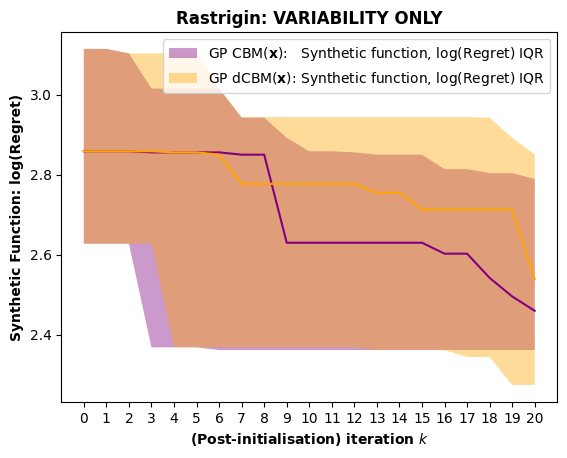

In [163]:
### Visualise!

cbm_both = ': VARIABILITY ONLY'
title = obj_func + cbm_both

plt.figure()

plt.plot(median_approx, color = 'Purple')
plt.plot(median_exact, color = 'Orange')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='GP CBM($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='GP dCBM($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


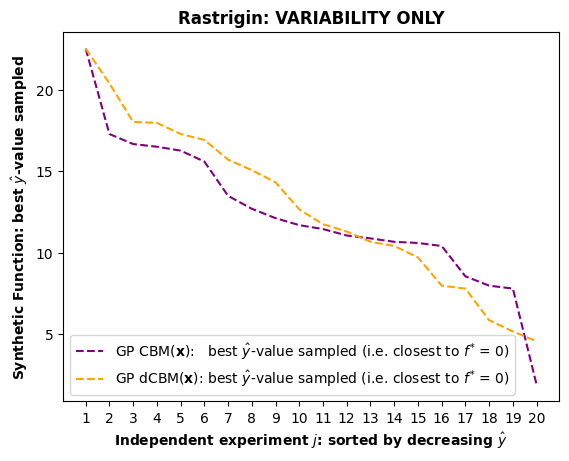

In [164]:
### Visualise!

cbm_both = ': VARIABILITY ONLY'
title = obj_func + cbm_both

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Purple', ls='--', label='GP CBM($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Orange', ls='--', label='GP dCBM($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


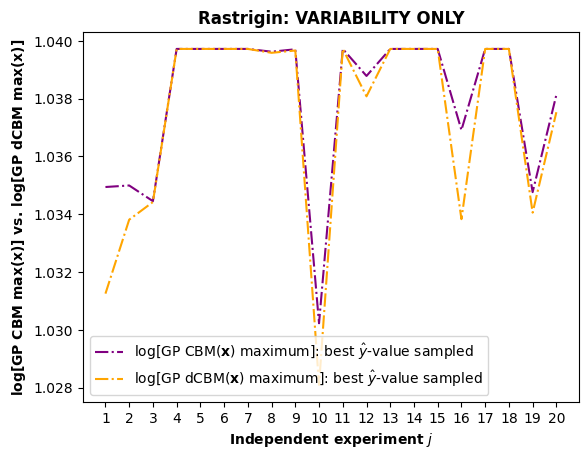

In [165]:
### Visualise!

cbm_both = ': VARIABILITY ONLY'
title = obj_func + cbm_both

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Purple', ls='-.', label='log[GP CBM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Orange', ls='-.', label='log[GP dCBM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP CBM max($\mathbf{x}$)] vs. log[GP dCBM max($\mathbf{x}$)]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


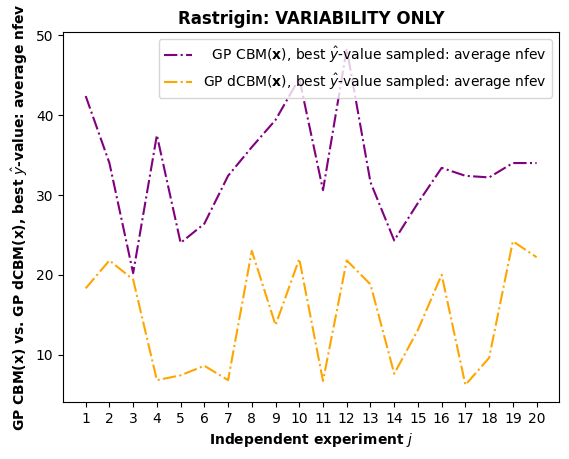

In [166]:
### Visualise!

cbm_both = ': VARIABILITY ONLY'
title = obj_func + cbm_both

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Purple', ls='-.', label='  GP CBM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Orange', ls='-.', label='GP dCBM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP CBM($\mathbf{x}$) vs. GP dCBM($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


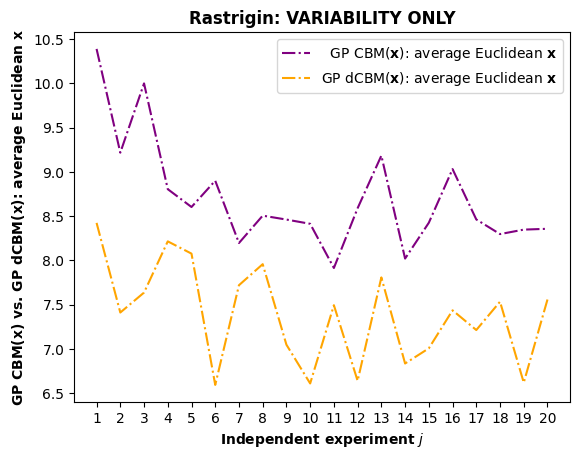

In [167]:
### Visualise!

cbm_both = ': VARIABILITY ONLY'
title = obj_func + cbm_both

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Purple', ls='-.', label='  GP CBM($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Orange', ls='-.', label='GP dCBM($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP CBM($\mathbf{x}$) vs. GP dCBM($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([2.7084, 2.7532, 2.8046, 2.8063, 2.7955, 2.805 , 2.7988, 2.7967,
        2.788 , 2.8063, 2.8046, 2.7773, 2.8062, 2.8062, 2.7084, 2.8063,
        2.7967, 2.7266, 2.7958, 2.7084]),
 2.8063,
 array([0.77965702, 5.12      ]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([2.5942, 2.7658, 2.7107, 2.7208, 2.7124, 2.8004, 2.7757, 2.7727,
        2.7677, 2.805 , 2.753 , 2.6481, 2.5926, 2.7124, 2.7466, 2.6425,
        2.7819, 2.7178, 2.6995, 2.793 ]),
 2.805,
 array([0.90975019, 5.12      ]))

In [170]:
np.round(approx_4.x_best, 4)


array([[-1.7807,  0.7569],
       [-5.12  , -2.5918],
       [-0.3853,  2.1524],
       [ 0.7796,  5.12  ],
       [-3.6586,  3.4661],
       [ 2.9734,  1.92  ],
       [ 3.3128,  3.1625],
       [ 3.6419, -3.7149],
       [-5.12  ,  0.6149],
       [ 0.7797,  5.12  ],
       [-0.3853,  2.1524],
       [ 0.3509, -3.8767],
       [-4.0721,  0.6599],
       [-4.0721,  0.6599],
       [-1.7807,  0.7569],
       [ 0.7797,  5.12  ],
       [ 3.6419, -3.7149],
       [ 4.4023, -1.0175],
       [ 0.9735, -1.1949],
       [-1.7807,  0.7569]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[-1.5382, -0.4508],
       [-3.9367, -2.1887],
       [ 0.1168,  1.3588],
       [ 1.518 ,  4.621 ],
       [-1.8884,  3.229 ],
       [ 2.974 ,  2.4335],
       [ 3.0799,  3.5639],
       [ 3.5758, -2.9231],
       [-3.6336,  0.1914],
       [ 0.9098,  5.12  ],
       [-5.12  , -2.6131],
       [ 1.4114, -4.1211],
       [-1.5348, -0.3518],
       [-3.7752, -0.5133],
       [-5.12  , -5.12  ],
       [ 2.1965,  4.1652],
       [ 3.3189, -4.7041],
       [ 4.2215, -0.8904],
       [ 1.7368, -1.775 ],
       [-0.1685,  1.8829]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


6.852231659262613

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

13.72060363273114